# Topic Modelling - Latent Dirichlet Allocation (LDA)

This notebook mainly covers the Topic Modelling Section of my Capstone Project.

**Topic modeling** is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. **Latent Dirichlet Allocation (LDA)** is an example of topic modelling and it is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [1]:
## Importing Basic Packages
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from bs4 import BeautifulSoup

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.colors as mcolors

In [2]:
# Reading in Combined Reviews CSV File

combined_reviews = pd.read_csv("Data/Part_2/sentiment_reviews.csv")
combined_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(combined_reviews.shape)
combined_reviews.head(3)

(253050, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.0,0,0,0,"In the heart of Chinatown, I discovered it enr...",2017-06-06 19:04:10,2017,6,19:04:10,244,1442,4.709163,93,heart chinatown discovered enroute kensington ...,0.213835,0.532102,0.030,0.767,0.204,0.9942
1,9Eghhu_LzEJgDKNgisf3rg,iFEM16O5BeKvf_AHs6NzUQ,3.0,0,0,0,Was super excited to bring my boyfriend to thi...,2016-08-25 16:25:12,2016,8,16:25:12,233,1323,4.659483,92,super excited bring boyfriend scaddabush locat...,0.188048,0.440286,0.016,0.892,0.091,0.9381
2,jM6JjZXFAQQANwdlEwbH3g,IIE2OX5haarGNefY23R8BA,5.0,0,0,0,My absolutely favorite mushroom pizza in the c...,2016-04-23 03:32:19,2016,4,03:32:19,43,240,4.829268,13,absolutely favorite mushroom pizza city great ...,0.400000,0.690000,0.000,0.781,0.219,0.8930


In [3]:
# Filtering for reviews that have 0.0 scores across 3 metrics: polarity, subjectivity, compound

dropped_reviews = combined_reviews[(combined_reviews.polarity ==0.0) & (combined_reviews.compound==0.0) & (combined_reviews.subjectivity==0.0)]
print(dropped_reviews.shape)
dropped_reviews.sample(5)

(630, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
34065,ejKXczjEkm1gzyRdblQm8w,gWbXQg0rPLDCRNR0HbImvA,4.0,1,0,0,It's vegetarian. What's more to say!,2015-11-20 21:03:36,2015,11,21:03:36,6,36,5.166667,2,vegetarian whats say,0.0,0.0,0.0,1.0,0.0,0.0
156091,826djy6K_9Fp0ptqJ2_Yag,YUrMj0-zS7jejLHEfPF-VA,5.0,0,0,0,N,2015-03-27 11:04:51,2015,3,11:04:51,1,1,1.000000,0,n,0.0,0.0,0.0,1.0,0.0,0.0
123548,LBHbyID7tcaGszznHtnCrw,32ESaaEAXVkan9wNfQ5Gjg,5.0,0,0,0,Un très bon restaurant bien qu'il soit légèrem...,2019-08-11 01:00:02,2019,8,01:00:02,24,164,5.875000,0,un très bon restaurant bien quil soit légèreme...,0.0,0.0,0.0,1.0,0.0,0.0
130552,RsXu_NNblaAHT3onHWlLIA,z9w399cBpCAKXhH_JA1AtQ,4.0,0,0,0,分店越来越多啦，位于401/kennedy附近的kinton ramen分店车位够多，唔需要...,2018-08-08 03:37:48,2018,8,03:37:48,2,154,76.500000,0,分店越来越多啦位于401kennedy附近的kinton ramen分店车位够多唔需要排队等...,0.0,0.0,0.0,1.0,0.0,0.0
37879,-av1lZI1JDY_RZN2eTMnWg,z9w399cBpCAKXhH_JA1AtQ,4.0,0,0,0,downtown RU學生同周邊白領飯堂甘，皆因地理位置好。\n[环境]位於dundas地鐵...,2019-01-08 15:58:16,2019,1,15:58:16,3,285,34.750000,0,downtown ru學生同周邊白領飯堂甘皆因地理位置好 环境位於dundas地鐵站以北ry...,0.0,0.0,0.0,1.0,0.0,0.0


As seen from the table above, it seems like these reviews are written in non-english languages or are gibberish. Thus, sentimet analysis libraries are not able to compute relevant scores for these reviews. Hence, for the purpose of this project, we will be removing these `630` rows of reviews.

In [4]:
# Dropping these filtered rows

combined_reviews = combined_reviews.drop(index = dropped_reviews.index)
print(combined_reviews.shape)
combined_reviews.sample(3)

(252420, 22)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
2650,Yt5gK4E9NqVa14WNiQdBlQ,iAnjJopiiFwS2sGY8w8AWg,4.0,0,0,0,This is my go to spot for good pho in my immed...,2016-10-15 02:17:34,2016,10,02:17:34,134,695,4.194030,63,go spot good pho immediate neighbourhood get h...,0.058673,0.608362,0.052,0.825,0.122,0.7440
227964,Yl2TN9c23ZGLUBSD9ks5Uw,yO6oA-hSOtjBoIBGLo_xZg,5.0,1,0,0,BY FAR my favourite place to go for a special ...,2019-09-29 22:01:07,2019,9,22:01:07,192,1034,4.359375,84,far favourite place go special night there lot...,0.326077,0.554422,0.006,0.720,0.274,0.9967
152156,Vf_RHj0f1VViEF6OYnEfUA,kVchO4eetmiFixYGBMR5Iw,5.0,0,0,0,I don't know why the rate for Quinn's is just ...,2017-01-29 22:04:26,2017,1,22:04:26,67,356,4.378788,29,dont know rate quinns 3 star guest love food l...,0.459962,0.559735,0.000,0.702,0.298,0.9807


In [5]:
# Converting words in reviews to a list

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list

data = combined_reviews.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['in', 'the', 'heart', 'of', 'chinatown', 'discovered', 'it', 'enroute', 'to', 'kensington', 'market', 'one', 'day', 'its', 'quite', 'hard', 'to', 'see', 'if', 'you', 'dont', 'know', 'its', 'there', 'first', 'experience', 'was', 'very', 'positive', 'would', 'definitely', 'return', 'atmosphere', 'small', 'space', 'think', 'banh', 'mi', 'boys', 'and', 'other', 'trendy', 'over', 'the', 'counter', 'eateries', 'vibe', 'is', 'casual', 'free', 'wifi', 'is', 'nice', 'service', 'okay', 'staff', 'does', 'their', 'job', 'but', 'not', 'overly', 'helpful', 'upon', 'entering', 'the', 'space', 'maybe', 'because', 'its', 'an', 'over', 'the', 'counter', 'style', 'place', 'but', 'it', 'would', 'have', 'been', 'nice', 'to', 'be', 'walked', 'through', 'their', 'ordering', 'process', 'and', 'menu', 'price', 'average', 'depends', 'on', 'the', 'size', 'of', 'pizza', 'you', 'order', 'the', 'small', 'pizza', 'is', 'filling', 'for', 'one', 'large', 'size', 'pizza', 'is', 'good', 'for', 'sharing', 'or', 'one', 

In [6]:
# Text Processing

import spacy

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [7]:
# Create Dictionary

id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data_ready]

In [8]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=42,
                                           chunksize=250,
                                           passes=5,
                                           alpha='auto',
                                           iterations=10,
                                           per_word_topics=False)

In [9]:
# Overview of Dominant Topics

pprint(lda_model.print_topics())

[(0,
  '0.022*"order" + 0.019*"time" + 0.018*"food" + 0.014*"table" + 0.012*"wait" '
  '+ 0.011*"give" + 0.010*"service" + 0.009*"place" + 0.009*"ask" + '
  '0.008*"eat"'),
 (1,
  '0.030*"great" + 0.027*"food" + 0.027*"place" + 0.017*"service" + '
  '0.012*"love" + 0.012*"delicious" + 0.011*"menu" + 0.011*"definitely" + '
  '0.011*"really" + 0.010*"friendly"'),
 (2,
  '0.027*"fry" + 0.021*"sauce" + 0.017*"burger" + 0.016*"chicken" + '
  '0.014*"salad" + 0.013*"cheese" + 0.013*"order" + 0.012*"meat" + '
  '0.011*"taste" + 0.011*"side"'),
 (3,
  '0.032*"pancake" + 0.021*"egg" + 0.019*"coffee" + 0.018*"sweet" + '
  '0.018*"cream" + 0.017*"tea" + 0.016*"ice" + 0.015*"taste" + 0.015*"dessert" '
  '+ 0.012*"flavour"'),
 (4,
  '0.021*"noodle" + 0.018*"place" + 0.017*"dish" + 0.017*"rice" + '
  '0.015*"chicken" + 0.015*"soup" + 0.015*"order" + 0.014*"price" + '
  '0.014*"food" + 0.011*"beef"')]


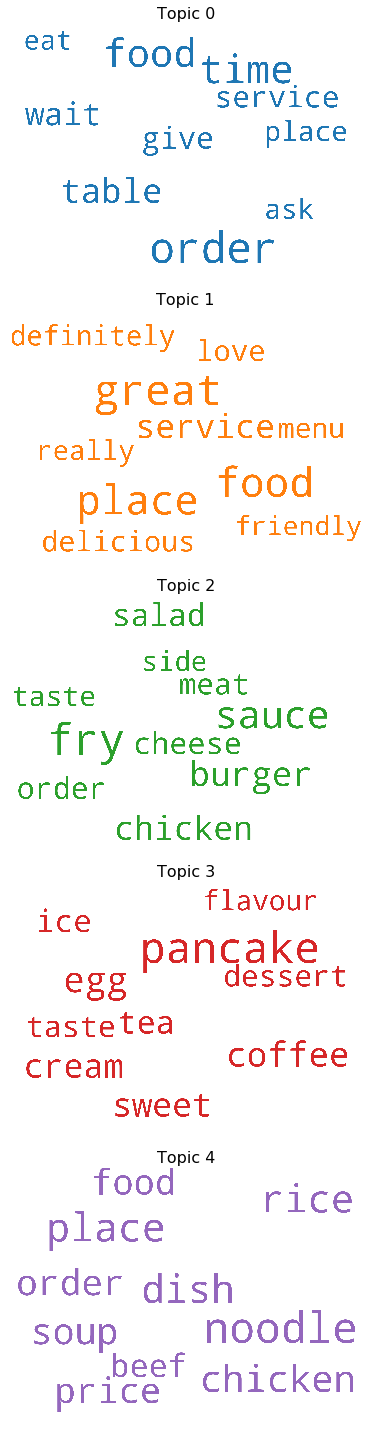

In [10]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Based on these plots, we can argue that topics 2, 3 and 4 exhibit unique characteristics as compared to topics 0 and 1. **Topic 2** showcases words commonly belonging to **Western Restaurants**. **Topic 3** showcases words belonging to **Dessert Restaurants**. **Topic 4** showcases words belonging to **Asian Restaurants.**

In [11]:
# 5 topics

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.233854 -0.082421       1        1  31.833002
1      0.170069 -0.099849       2        1  29.195801
4      0.035806  0.162733       3        1  16.578291
2     -0.136861  0.218942       4        1  15.387690
3     -0.302867 -0.199405       5        1   7.005217, topic_info=        Term           Freq          Total Category  logprob  loglift
137    great  104277.000000  104277.000000  Default  30.0000  30.0000
521      fry   60671.000000   60671.000000  Default  29.0000  29.0000
696   noodle   41608.000000   41608.000000  Default  28.0000  28.0000
733  pancake   26626.000000   26626.000000  Default  27.0000  27.0000
468  chicken   60096.000000   60096.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
433  texture    5149.831055    8990.638672   Topic5  -5.0994   2.1013
59      rich    4143.426758    5508.380371   Topic5  -5.3168   2.3738
313   flavor    4904.919922   14351.921875   Topic5  -5.1481   1.5849
551      top    4375.576172   22133.123047   Topic5  -5.2623   1.0375
118   really    4172.337402   83116.515625   Topic5  -5.3098  -0.3333

[321 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
131       1  0.069692     always
131       2  0.750475     always
131       3  0.179811     always
245       2  0.999973    amazing
360       2  0.999822   ambiance
...     ...       ...        ...
79        5  0.031136       well
1564      5  0.999757       whip
558       2  0.999941       wine
2237      4  0.999938       wing
629       2  0.999957  wonderful

[484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

In [12]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [13]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

In [14]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(252420, 4)


,Document_No,Dominant_Topic,Keywords,Text
0,0,1.0,"great, food, place, service, love, delicious, ...","[heart, chinatown, discover, enroute, kensingt..."
1,1,0.0,"order, time, food, table, wait, give, service,...","[super, excited, bring, boyfriend, scaddabush,..."
2,2,1.0,"great, food, place, service, love, delicious, ...","[absolutely, favorite, mushroom, pizza, city, ..."
3,3,1.0,"great, food, place, service, love, delicious, ...","[couple, time, excellent, food, price, love, t..."
4,4,0.0,"order, time, food, table, wait, give, service,...","[pizza, arrive, minute, close, time, restauran..."
5,5,0.0,"order, time, food, table, wait, give, service,...","[eatery, choose, queen, street, decide, give, ..."
6,6,1.0,"great, food, place, service, love, delicious, ...","[amazing, place, co, worker, saturday, celebra..."
7,7,1.0,"great, food, place, service, love, delicious, ...","[place, small, cozy, love, really, great, food..."
8,8,4.0,"noodle, place, dish, rice, chicken, soup, orde...","[great, ayce, sushi, place, visit, least, mont..."
9,9,1.0,"great, food, place, service, love, delicious, ...","[honestly, little, sweet, liking, expect, trip..."


In [15]:
# Append new columns onto reviews dataset

df_dominant_topic['Text_Chunks'] = df_dominant_topic['Text']
extra_feature_columns = df_dominant_topic[['Dominant_Topic', 'Keywords', 'Text_Chunks']]
final_reviews = pd.concat([combined_reviews,extra_feature_columns], axis=1).reindex(combined_reviews.index)
final_reviews.head(10)

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,4.0,0.0,0.0,0.0,"In the heart of Chinatown, I discovered it enr...",2017-06-06 19:04:10,2017.0,6.0,19:04:10,244.0,1442.0,4.709163,93.0,heart chinatown discovered enroute kensington ...,0.213835,0.532102,0.030,0.767,0.204,0.9942,1.0,"great, food, place, service, love, delicious, ...","[heart, chinatown, discover, enroute, kensingt..."
1,9Eghhu_LzEJgDKNgisf3rg,iFEM16O5BeKvf_AHs6NzUQ,3.0,0.0,0.0,0.0,Was super excited to bring my boyfriend to thi...,2016-08-25 16:25:12,2016.0,8.0,16:25:12,233.0,1323.0,4.659483,92.0,super excited bring boyfriend scaddabush locat...,0.188048,0.440286,0.016,0.892,0.091,0.9381,0.0,"order, time, food, table, wait, give, service,...","[super, excited, bring, boyfriend, scaddabush,..."
2,jM6JjZXFAQQANwdlEwbH3g,IIE2OX5haarGNefY23R8BA,5.0,0.0,0.0,0.0,My absolutely favorite mushroom pizza in the c...,2016-04-23 03:32:19,2016.0,4.0,03:32:19,43.0,240.0,4.829268,13.0,absolutely favorite mushroom pizza city great ...,0.400000,0.690000,0.000,0.781,0.219,0.8930,1.0,"great, food, place, service, love, delicious, ...","[absolutely, favorite, mushroom, pizza, city, ..."
3,PMPMHHLe9vFzcR67iCjgLA,RRhco4irDXPk5EJmvuwr2w,5.0,0.0,0.0,2.0,Been to this a couple of times. Excellent food...,2016-01-17 05:23:59,2016.0,1.0,05:23:59,28.0,148.0,4.321429,11.0,couple time excellent food good price love tea...,0.529167,0.700000,0.000,0.530,0.470,0.9612,1.0,"great, food, place, service, love, delicious, ...","[couple, time, excellent, food, price, love, t..."
4,tWdp26XQEJqJGnRmFVJQxA,IeojscL3rg3x3vtmR-hWlA,4.0,0.0,0.0,0.0,"The pizza is very, very good! We arrived 15 mi...",2018-07-17 01:49:01,2018.0,7.0,01:49:01,20.0,121.0,5.100000,7.0,pizza good arrived 15 minute closing time rest...,0.700000,0.600000,0.000,0.824,0.176,0.6194,0.0,"order, time, food, table, wait, give, service,...","[pizza, arrive, minute, close, time, restauran..."
5,tJcpzXzykNSLuzWwa1JQUw,6WmMHMBM4FLGyK98-reecA,1.0,1.0,1.0,1.0,With many eateries to chose from on queen stre...,2016-05-31 01:21:11,2016.0,5.0,01:21:11,341.0,1821.0,4.340176,136.0,many eatery chose queen street decided give pl...,0.079401,0.479401,0.068,0.859,0.073,0.2741,0.0,"order, time, food, table, wait, give, service,...","[eatery, choose, queen, street, decide, give, ..."
6,28adZ4lsuUeVB2aWzohK9g,BwwqlPVsJk1dbUyNwCWB7Q,5.0,0.0,0.0,0.0,Amazing place! My co-workers and I went here o...,2017-11-06 22:08:35,2017.0,11.0,22:08:35,194.0,1013.0,4.174359,84.0,amazing place coworkers went saturday celebrat...,0.422787,0.521120,0.000,0.759,0.241,0.9958,1.0,"great, food, place, service, love, delicious, ...","[amazing, place, co, worker, saturday, celebra..."
7,uG0yvj2JWfCf0eaIgxcwXQ,yiLiYYg6MM7Pmuo6jPY4Nw,5.0,0.0,0.0,0.0,"This place is very small and cozy, but what I ...",2015-03-07 13:40:01,2015.0,3.0,13:40:01,67.0,364.0,4.388060,30.0,place small cozy love really get great food pr...,0.292857,0.479592,0.000,0.743,0.257,0.9771,1.0,"great, food, place, service, love, delicious, ...","[place, small, cozy, love, really, great, food..."
8,W7Ua8ELRMm3IPd23fp7XjA,9rMg4ePrSLCqvzebAlUStQ,4.0,0.0,0.0,0.0,This is another great ayce sushi place I visit...,2015-06-21 00:56:43,2015.0,6.0,00:56:43,62.0,340.0,4.500000,23.0,another great ayce sushi place visit least mon...,-0.189583,0.591667,0.097,0.844,0.059,-0.4019,4.0,"noodle, place, dish, rice, chicken, soup, orde...","[great, ayce, sushi, place, visit, least, mont..."
9,3VHJGvjHeEki7Hiyt-Hv5g,bFh4EO-u9U8uhMyxATvEjQ,4.0,0.0,0.0,0.0,Honestly a little too sweet for my liking but ...,2017-10-11 04:02:35,2017.0,10.0,04:02:35,58.0,308.0,4.327586,22.0,honestly little sweet liking expected getting ...,0.285985,0.518182,0.056,0.593,0.351,0.9761,1.0,"great, food, place, service, love, delicious, ...","[honestly, little, s

In [17]:
# Save final_reviews into csv file

final_reviews.to_csv("Data/Part_3/final_reviews.csv")